<a href="https://colab.research.google.com/github/grecalde17gh/pln-lstm-stock-prediction/blob/main/Portafolio_de_inversiones_PT_v51.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto FINAL | Gustavo Recalde**

# **Optimización de Portafolios de Inversión usando Redes LSTM y PLN**


## **Dependencias y librerias**

### Lightning, Vader, Praw

In [3]:
!pip install pytorch-lightning
!pip install vaderSentiment
!pip install praw
!pip install asyncpraw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 8.2 MB/s eta 0:00:00


### Librerias

In [14]:
# Importar librerías y configurar la semilla
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.optimize import minimize
import os

# Configuración de la semilla para reproducibilidad
np.random.seed(4)
torch.manual_seed(4)


## **Recolección y Procesamiento de Datos**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Datos para AMZN descargados.
Datos para GOOGL descargados.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Datos para NVDA descargados.
Datos para MSFT descargados.


[*********************100%***********************]  1 of 1 completed


Datos para NFLX descargados.


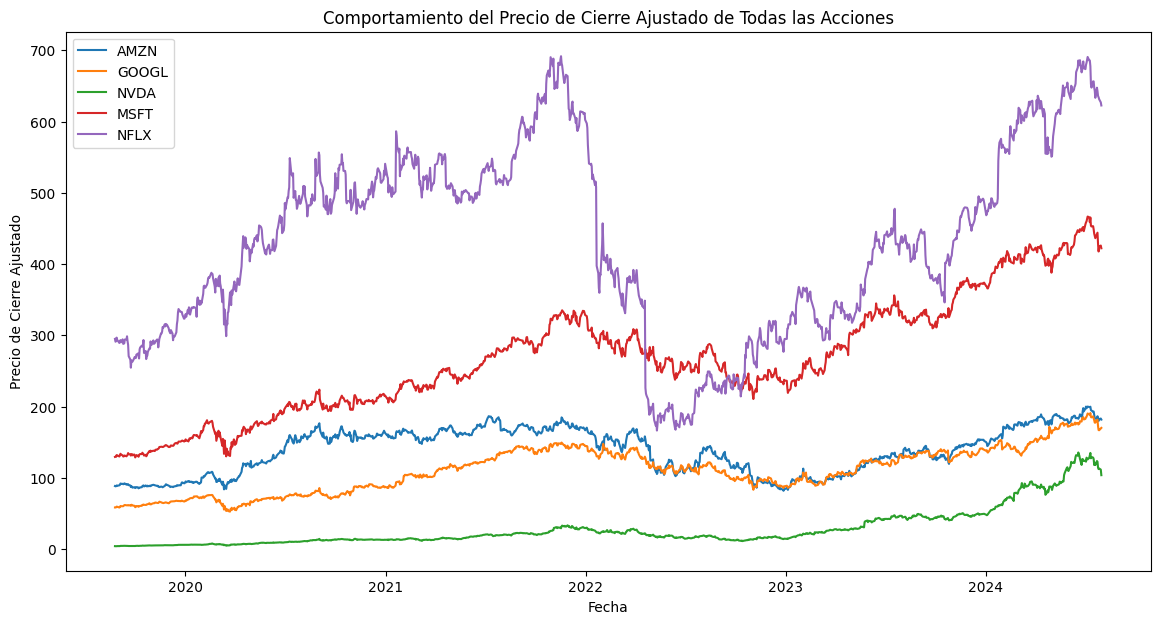

In [55]:
# Recolección y procesamiento de datos

# Lista de tickers
tickers = ['AMZN', 'GOOGL', 'NVDA', 'MSFT', 'NFLX']

# Descargar datos de Yahoo Finance para cada ticker
def download_data(ticker):
    data = yf.download(ticker, start='2019-06-01', end='2024-07-31')
    data['MA_10'] = data['Adj Close'].rolling(window=10).mean()
    data['MA_30'] = data['Adj Close'].rolling(window=30).mean()
    data['MA_60'] = data['Adj Close'].rolling(window=60).mean()
    data.dropna(inplace=True)  # Eliminar filas con valores NaN debido al cálculo de medias móviles
    return data

# Descargar y almacenar datos para cada ticker
data_dict = {}
for ticker in tickers:
    data_dict[ticker] = download_data(ticker)
    print(f"Datos para {ticker} descargados.")

# Graficar el comportamiento del precio de cierre ajustado de todas las acciones
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(data_dict[ticker].index, data_dict[ticker]['Adj Close'], label=ticker)
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado')
plt.title('Comportamiento del Precio de Cierre Ajustado de Todas las Acciones')
plt.legend()
plt.show()


## **Funciones Auxiliares**

In [56]:
# Función para graficar las predicciones con fechas en el eje x
def graficar_predicciones(real, prediccion, dates, ticker):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, real, color='red', label='Valor real de la acción')
    plt.plot(dates[len(dates) - len(prediccion):], prediccion, color='blue', label='Predicción de la acción')
    plt.xlabel('Fecha')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.title(f'Predicciones para {ticker}')
    plt.xticks(rotation=45)
    plt.show()

# Callback para registrar la pérdida durante el entrenamiento
class LossLogger(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        logs = trainer.logged_metrics
        epoch = trainer.current_epoch
        loss = logs['train_loss_epoch'].item()
        if not hasattr(self, 'losses'):
            self.losses = []
        self.losses.append((epoch, loss))

# Función para graficar la pérdida durante el entrenamiento
def plot_loss(callback, ticker):
    epochs, losses = zip(*callback.losses)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses, label='Pérdida de Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title(f'Pérdida durante el Entrenamiento para {ticker}')
    plt.legend()
    plt.show()

# **Modelo 1. LSTM Usando unicamente datos financieros**

In [57]:
# Definir el modelo LSTM en PyTorch Lightning

class LSTMModel(pl.LightningModule):
    def __init__(self, input_size=4, hidden_layer_size=100, output_size=1, lr=0.001):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.lr = lr
        self.criterion = nn.MSELoss()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss_epoch', loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


## **Entrenamiento y prediccion**

In [58]:
# Función para entrenar modelos y hacer predicciones para cada ticker

def train_and_predict(ticker):
    data = data_dict[ticker]

    # Sets de entrenamiento y validación
    set_entrenamiento = data[:'2023-06-30'].loc[:, ['Adj Close', 'MA_10', 'MA_30', 'MA_60']]
    set_validacion = data['2023-07-01':].loc[:, ['Adj Close', 'MA_10', 'MA_30', 'MA_60']]

    # Normalización del set de entrenamiento y validación
    sc = MinMaxScaler(feature_range=(0, 1))
    set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)
    set_validacion_escalado = sc.transform(set_validacion)

    # Preparar datos para PyTorch
    time_step = 60
    X_train = []
    Y_train = []
    m = len(set_entrenamiento_escalado)

    for i in range(time_step, m):
        X_train.append(set_entrenamiento_escalado[i-time_step:i])
        Y_train.append(set_entrenamiento_escalado[i, 0])  # Usar solo la columna 'Adj Close'

    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)

    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    model_path = f'{ticker}_model.pth'
    if os.path.exists(model_path):
        model = LSTMModel()
        model.load_state_dict(torch.load(model_path))
        print(f"Modelo cargado para {ticker}.")
        final_loss = None  # No tenemos pérdida final al cargar el modelo
    else:
        # Entrenamiento del modelo
        model = LSTMModel()
        loss_logger = LossLogger()
        trainer = pl.Trainer(max_epochs=20, logger=False, callbacks=[loss_logger])
        trainer.fit(model, train_loader)

        # Guardar el modelo
        torch.save(model.state_dict(), model_path)
        print(f"Modelo guardado para {ticker}.")

        # Graficar la pérdida durante el entrenamiento
        plot_loss(loss_logger, ticker)
        final_loss = loss_logger.losses[-1][1] if hasattr(loss_logger, 'losses') else None

    # Preparar datos de validación para la predicción
    X_test = []
    for i in range(time_step, len(set_validacion_escalado)):
        X_test.append(set_validacion_escalado[i-time_step:i])

    X_test = np.array(X_test)
    X_test = torch.tensor(X_test, dtype=torch.float32)

    # Predicción
    model.eval()
    with torch.no_grad():
        prediccion = model(X_test).numpy()

    prediccion = sc.inverse_transform(np.concatenate([prediccion, np.zeros((prediccion.shape[0], 3))], axis=1))[:, 0]

    # Graficar las predicciones
    graficar_predicciones(set_validacion.values[:, 0], prediccion, set_validacion.index, ticker)

    # Calcular métricas de evaluación
    mse = mean_squared_error(set_validacion.values[time_step:, 0], prediccion)
    mae = mean_absolute_error(set_validacion.values[time_step:, 0], prediccion)
    r2 = r2_score(set_validacion.values[time_step:, 0], prediccion)

    print(f"Mean Squared Error (MSE) para {ticker}: {mse}")
    print(f"Mean Absolute Error (MAE) para {ticker}: {mae}")
    print(f"R^2 Score para {ticker}: {r2}")

    return {
        "ticker": ticker,
        "mse": mse,
        "mae": mae,
        "r2": r2,
        "final_loss": final_loss,
        "prediccion": prediccion  # Añadir las predicciones a los resultados
    }


Procesando AMZN...
Modelo cargado para AMZN.


<ipython-input-58-ba7527f363f1>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


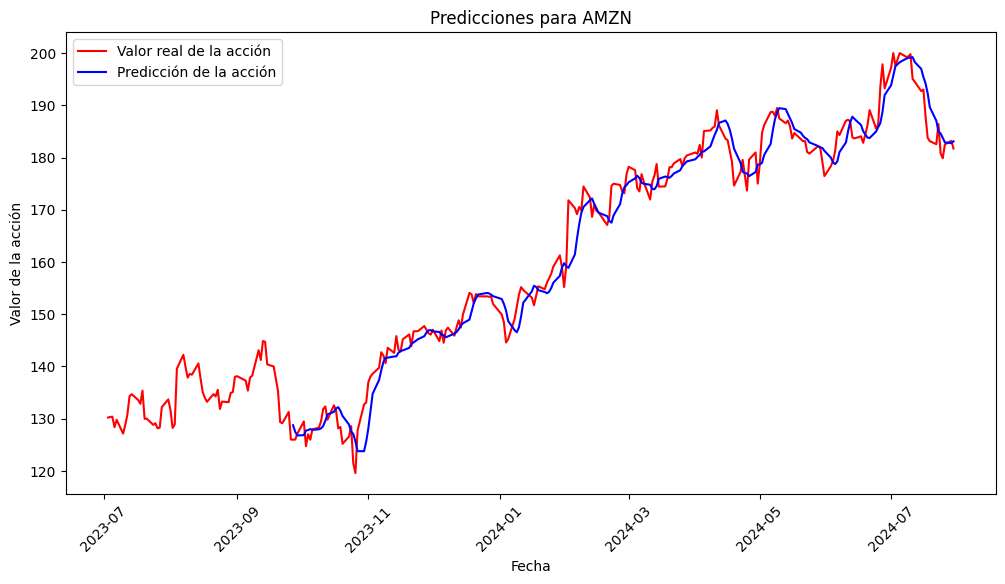

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 42.4 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
42.5 K    Trainable params
0         Non-trainable params
42.5 K    Total params
0.170     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Mean Squared Error (MSE) para AMZN: 11.059908114921592
Mean Absolute Error (MAE) para AMZN: 2.5437470323569547
R^2 Score para AMZN: 0.9752276530576317
Procesando GOOGL...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Modelo guardado para GOOGL.


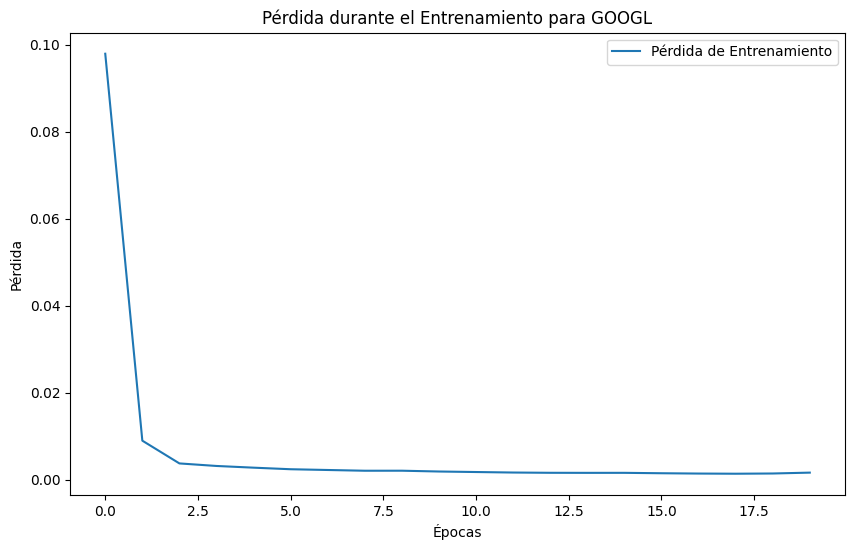

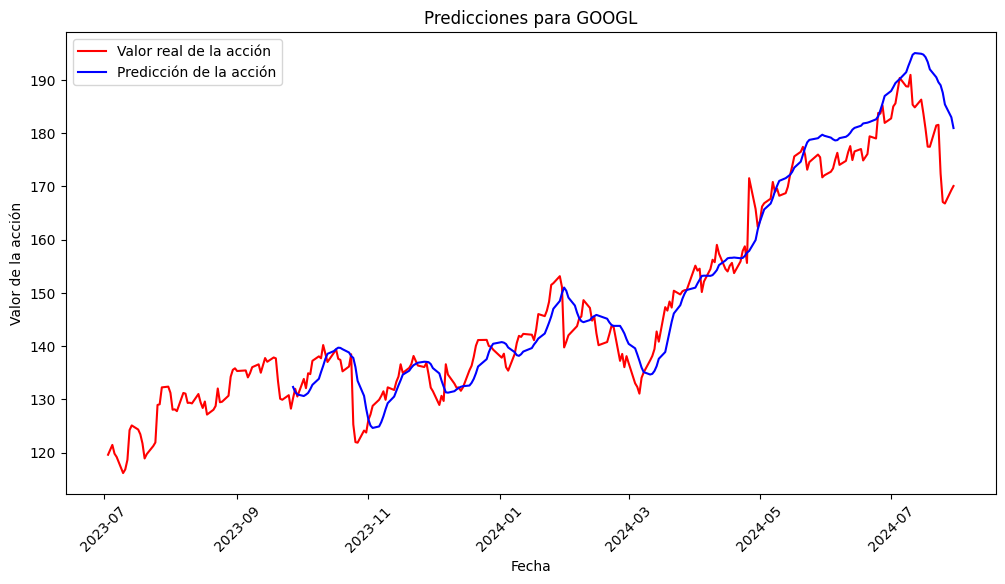

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 42.4 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
42.5 K    Trainable params
0         Non-trainable params
42.5 K    Total params
0.170     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Mean Squared Error (MSE) para GOOGL: 27.08585711882479
Mean Absolute Error (MAE) para GOOGL: 3.799927513379215
R^2 Score para GOOGL: 0.9193465818787983
Procesando NVDA...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Modelo guardado para NVDA.


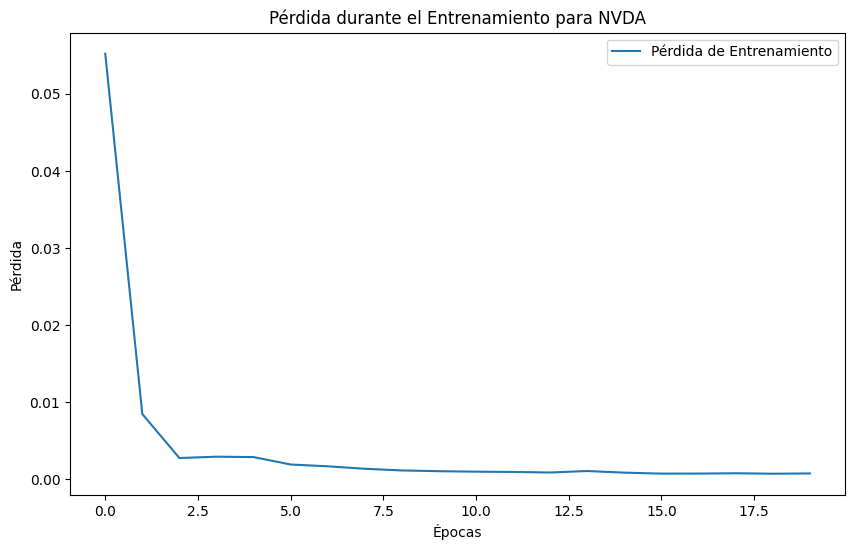

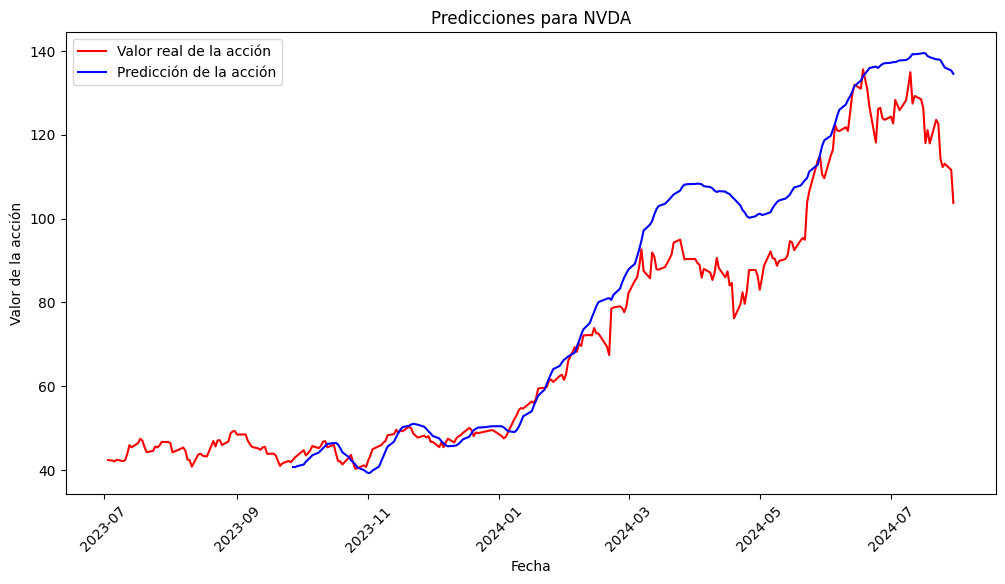

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 42.4 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
42.5 K    Trainable params
0         Non-trainable params
42.5 K    Total params
0.170     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Mean Squared Error (MSE) para NVDA: 108.94936780360437
Mean Absolute Error (MAE) para NVDA: 7.538812387814535
R^2 Score para NVDA: 0.8695088365815598
Procesando MSFT...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Modelo guardado para MSFT.


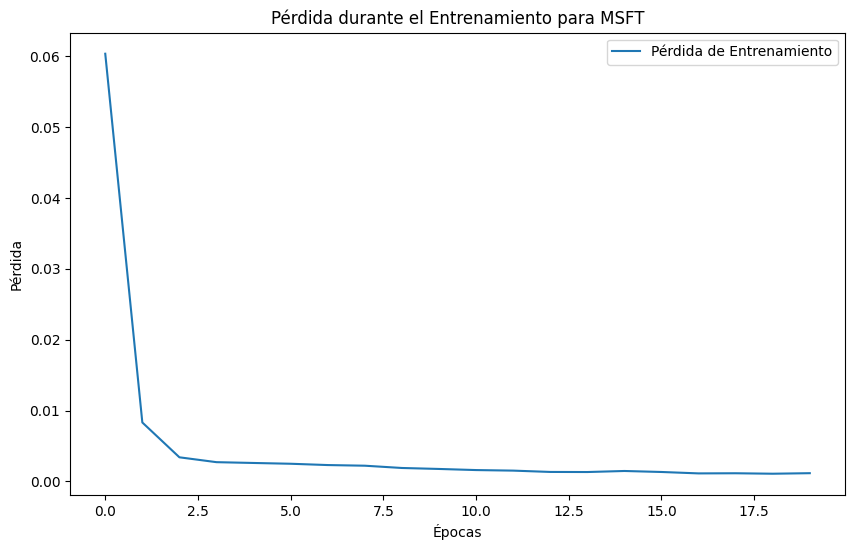

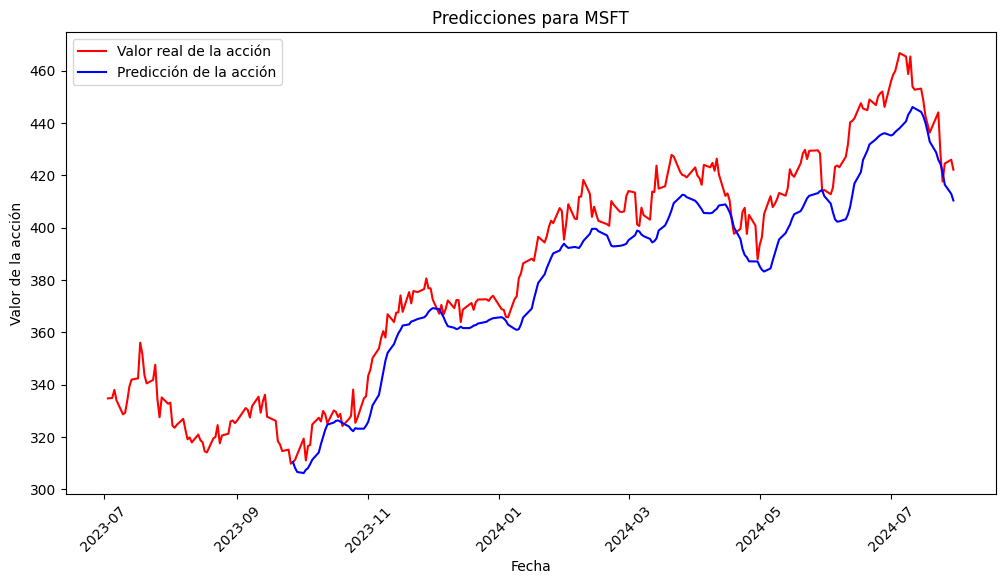

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 42.4 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
42.5 K    Trainable params
0         Non-trainable params
42.5 K    Total params
0.170     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Mean Squared Error (MSE) para MSFT: 192.58912182973512
Mean Absolute Error (MAE) para MSFT: 12.059132076508188
R^2 Score para MSFT: 0.8607330428441851
Procesando NFLX...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Modelo guardado para NFLX.


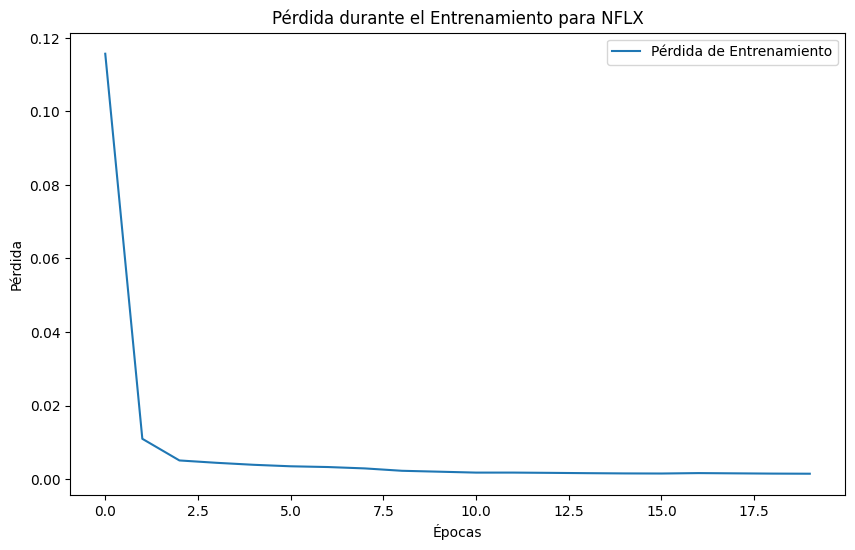

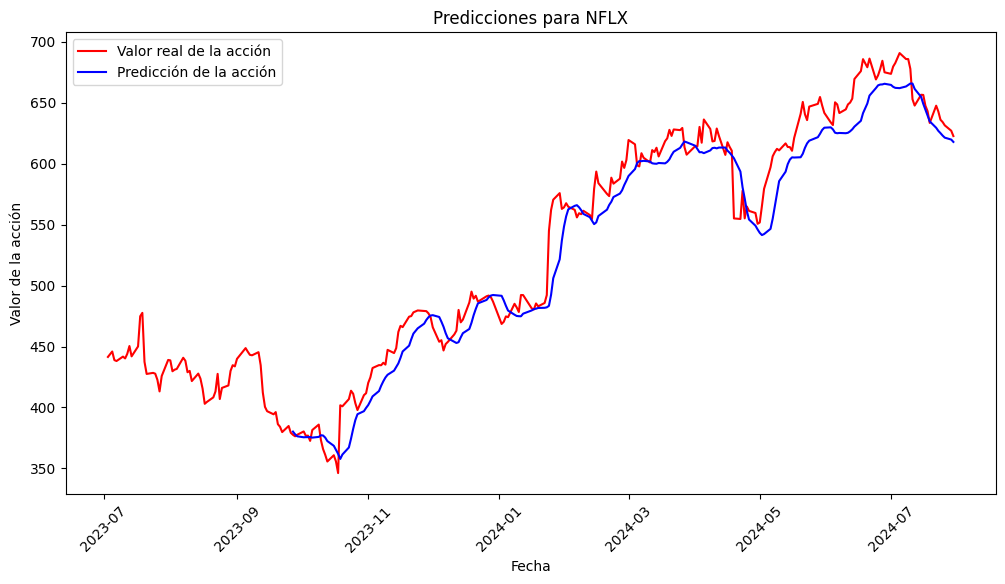

Mean Squared Error (MSE) para NFLX: 421.82141709828284
Mean Absolute Error (MAE) para NFLX: 15.874977666725904
R^2 Score para NFLX: 0.9524098304975527
  ticker         mse        mae        r2  final_loss
0   AMZN   11.059908   2.543747  0.975228         NaN
1  GOOGL   27.085857   3.799928  0.919347    0.001585
2   NVDA  108.949368   7.538812  0.869509    0.000772
3   MSFT  192.589122  12.059132  0.860733    0.001155
4   NFLX  421.821417  15.874978  0.952410    0.001452
           AMZN       GOOGL        NVDA        MSFT        NFLX
0    128.728559  132.331611   40.745039  310.456146  380.210044
1    127.461289  131.386046   40.738836  308.158237  377.976531
2    126.780747  130.920933   40.952966  306.648460  376.355863
3    126.825408  130.629394   41.344055  306.227034  375.546335
4    127.711277  130.885248   42.013738  307.475308  375.654735
..          ...         ...         ...         ...         ...
206  184.607871  188.985989  137.760611  424.368644  624.995510
207  183.7819

In [59]:
# Almacenar resultados
resultados = []
predicciones = {}

# Hacer predicciones para cada ticker y almacenar métricas
for ticker in tickers:
    print(f"Procesando {ticker}...")
    resultado = train_and_predict(ticker)
    resultados.append(resultado)
    predicciones[ticker] = resultado['prediccion']

# Crear DataFrame con resultados
resultados_df = pd.DataFrame(resultados)
resultados_df = resultados_df[['ticker', 'mse', 'mae', 'r2', 'final_loss']]

# Mostrar la tabla de resultados
print(resultados_df)

# Guardar las predicciones futuras en un DataFrame
future_prices_df = pd.DataFrame(predicciones)
print(future_prices_df)


# **MODELO 2. LSTM con información adicional de noticias y análisis de sentimientos**

## **Extracción de Datos Financieros**

In [19]:
import yfinance as yf

# Descargar datos financieros de AAPL
def download_data(ticker):
    data = yf.download(ticker, start='2020-06-01', end='2024-06-30')
    data['MA_10'] = data['Adj Close'].rolling(window=10).mean()
    data['MA_30'] = data['Adj Close'].rolling(window=30).mean()
    data['MA_60'] = data['Adj Close'].rolling(window=60).mean()
    data.dropna(inplace=True)  # Eliminar filas con valores NaN debido al cálculo de medias móviles
    return data

# Descargar datos financieros de AAPL
ticker = 'AAPL'
data = download_data(ticker)
print(data.head())

[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-08-24  128.697495  128.785004  123.937500  125.857498  122.993607   
2020-08-25  124.697502  125.180000  123.052498  124.824997  121.984573   
2020-08-26  126.180000  126.992500  125.082497  126.522499  123.643463   
2020-08-27  127.142502  127.485001  123.832497  125.010002  122.165382   
2020-08-28  126.012497  126.442497  124.577499  124.807503  121.967484   

               Volume       MA_10       MA_30      MA_60  
Date                                                      
2020-08-24  345937600  114.013449  103.624976  94.947141  
2020-08-25  211495600  115.523291  104.535187  95.672049  
2020-08-26  163022400  116.843793  105.478990  96.418550  
2020-08-27  155552400  117.821039  106.412624  97.133181  
2020-08-28  187630000  118.788510  107.346003  97.855894  


## **Extracción de Noticias Financieras**

In [20]:
def obtener_noticias_yfinance(ticker):
    stock = yf.Ticker(ticker)
    noticias = stock.news
    return noticias

# Obtener noticias de AAPL
noticias_yf = obtener_noticias_yfinance(ticker)

# Mostrar un resumen de las primeras noticias obtenidas
for noticia in noticias_yf[:5]:
    print(f"Fecha: {noticia['providerPublishTime']}")
    print(f"Fuente: {noticia['publisher']}")
    print(f"Titulo: {noticia['title']}")
    print(f"Enlace: {noticia['link']}\n")


Fecha: 1726263919
Fuente: Zacks
Titulo: Apple (AAPL) Stock Drops Despite Market Gains: Important Facts to Note
Enlace: https://finance.yahoo.com/news/apple-aapl-stock-drops-despite-214519779.html

Fecha: 1726257850
Fuente: Investor's Business Daily
Titulo: Apple Begins Taking Preorders For AI-Enabled iPhone 16 Handsets
Enlace: https://finance.yahoo.com/m/b92b0d3f-72c2-35ce-ad46-c9a1915b22cf/apple-begins-taking-preorders.html

Fecha: 1726249762
Fuente: MT Newswires
Titulo: Apple Seeks Dismissal of Lawsuit Against Israeli Cyber Intelligence Firm NSO Group
Enlace: https://finance.yahoo.com/news/apple-seeks-dismissal-lawsuit-against-174922373.html

Fecha: 1726248205
Fuente: Investopedia
Titulo: FDA Approves OTC Hearing Aid Software Device for Apple AirPods Pro
Enlace: https://finance.yahoo.com/m/501763bd-b8a2-353f-b37c-be2380783f4a/fda-approves-otc-hearing-aid.html

Fecha: 1726246621
Fuente: TechCrunch
Titulo: Alternative app stores will be allowed on Apple iPad in the EU from September 16

## **Extracción de publicaciones de Reddit**

In [21]:
import nest_asyncio
import asyncio
import asyncpraw

nest_asyncio.apply()

async def obtener_reddit_async(ticker, cliente_id, cliente_secret, usuario, contraseña, user_agent, subreddit='WallStreetBets', limite=100):
    reddit = asyncpraw.Reddit(client_id=cliente_id,
                              client_secret=cliente_secret,
                              user_agent=user_agent,
                              username=usuario,
                              password=contraseña)

    subreddit = await reddit.subreddit(subreddit)
    publicaciones = subreddit.search(ticker, limit=limite)
    datos = []
    async for post in publicaciones:
        datos.append({
            'titulo': post.title,
            'cuerpo': post.selftext,
            'fecha': post.created_utc
        })
    return datos

# Ejecutar la función asíncrona
cliente_id = "H3cf4dEtELCFz7w3z6eIKw"
cliente_secret = "lxNt3eDn3Y1XA57EIq3_Q92AQ_Ntyw"
usuario = "RoutineStrain7301"
contraseña = "Tavinr1717*"
user_agent = "proyectogustav"

# Ejecutar la función para obtener los posts de Reddit de AAPL
reddit_posts = asyncio.run(obtener_reddit_async(ticker, cliente_id, cliente_secret, usuario, contraseña, user_agent))

# Mostrar un resumen de los primeros posts obtenidos
for post in reddit_posts[:5]:
    print(f"Fecha: {post['fecha']}")
    print(f"Título: {post['titulo']}")
    print(f"Cuerpo: {post['cuerpo']}\n")


Fecha: 1724950083.0
Título: AAPL; please stay up this time to keep over 7 figures
Cuerpo: 

Fecha: 1722691855.0
Título: My theory why buffet sold aapl
Cuerpo: Everyone is freaking out about recession and also citing buffet selling half his stake in aapl as proof. But the reality is buffet doesn't time the market he holds good companies through recessions. But if you look at a lot of his other moves, sold all his TSM and a large portion of BYD as well. Its clear that buffet has geopolitical risks on the top of his mind, aapl would be obliterated in the case of a taiwan war. 

Afterall, why wouldn't he sell his American express position in a material way, wouldn't they get hit hard in a recession as well with delinquencies and decreased consumer spending? 

I guess this post doesn't really offer much reassurance as a taiwan war would be worse than a recession. But honestly I think you should trade like it wouldn't happen because if it does it would probably devolve into nuclear war and c

## **Analisis de sentimientos con VADER**

In [22]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import datetime

# Inicializar VADER
analyzer = SentimentIntensityAnalyzer()

# Función para analizar el sentimiento usando VADER
def analizar_sentimiento_vader(texto):
    scores = analyzer.polarity_scores(texto)
    return scores['compound']

# Convertir timestamps a fechas legibles
def convertir_fecha(timestamp):
    if isinstance(timestamp, (int, float)):  # Si es un número, conviértelo
        return datetime.datetime.fromtimestamp(timestamp)
    elif isinstance(timestamp, datetime.datetime):  # Si ya es un objeto datetime, devuélvelo tal cual
        return timestamp
    else:
        raise ValueError(f"Tipo de timestamp inesperado: {type(timestamp)}")

# Limpiar texto y analizar sentimiento
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

def limpiar_texto(texto):
    # Mantener símbolos financieros como % y +/-
    texto = re.sub(r'[^a-zA-Z0-9%+-]', ' ', texto)
    texto = texto.lower()
    tokens = texto.split()
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Procesar noticias de yfinance
def procesar_noticias_yf(noticias_yf):
    for noticia in noticias_yf:
        fecha = convertir_fecha(noticia['providerPublishTime'])
        noticia['fecha'] = fecha
        descripcion = noticia.get('description', '')
        texto_completo = noticia['title'] + " " + descripcion
        noticia['sentimiento'] = analizar_sentimiento_vader(limpiar_texto(texto_completo))
    return noticias_yf

# Procesar posts de Reddit
def procesar_reddit_posts(reddit_posts):
    for post in reddit_posts:
        fecha = convertir_fecha(post['fecha'])
        post['fecha'] = fecha
        post['sentimiento'] = analizar_sentimiento_vader(limpiar_texto(post['titulo'] + " " + post['cuerpo']))
    return reddit_posts

# Procesar los datos obtenidos
noticias_yf_procesadas = procesar_noticias_yf(noticias_yf)
reddit_posts_procesados = procesar_reddit_posts(reddit_posts)

# Mostrar un resumen
for noticia in noticias_yf_procesadas[:3]:
    print(f"Fecha: {noticia['fecha']}, Sentimiento: {noticia['sentimiento']}, Titulo: {noticia['title']}")

for post in reddit_posts_procesados[:3]:
    print(f"Fecha: {post['fecha']}, Sentimiento: {post['sentimiento']}, Título: {post['titulo']}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Fecha: 2024-09-13 21:45:19, Sentimiento: -0.6671, Titulo: Apple (AAPL) Stock Drops Despite Market Gains: Important Facts to Note
Fecha: 2024-09-13 20:04:10, Sentimiento: 0.0, Titulo: Apple Begins Taking Preorders For AI-Enabled iPhone 16 Handsets
Fecha: 2024-09-13 17:49:22, Sentimiento: 0.296, Titulo: Apple Seeks Dismissal of Lawsuit Against Israeli Cyber Intelligence Firm NSO Group
Fecha: 2024-08-29 16:48:03, Sentimiento: 0.3182, Título: AAPL; please stay up this time to keep over 7 figures
Fecha: 2024-08-03 13:30:55, Sentimiento: -0.9488, Título: My theory why buffet sold aapl
Fecha: 2024-07-30 14:01:57, Sentimiento: 0.8625, Título: aapl earnings YOLO


## **Sincronización de los sentimientos con los datos financieros**

In [23]:
# Crear DataFrames de noticias y Reddit
noticias_df = pd.DataFrame(noticias_yf_procesadas)
noticias_df['fecha'] = noticias_df['fecha'].dt.date

reddit_df = pd.DataFrame(reddit_posts_procesados)
reddit_df['fecha'] = reddit_df['fecha'].dt.date

# Sentimientos promedios diarios
sentimiento_noticias_diario = noticias_df.groupby('fecha')['sentimiento'].mean()
sentimiento_reddit_diario = reddit_df.groupby('fecha')['sentimiento'].mean()

# Añadir a los datos financieros de AAPL
data['sentimiento_noticias'] = data.index.map(sentimiento_noticias_diario)
data['sentimiento_reddit'] = data.index.map(sentimiento_reddit_diario)

# Rellenar NaN
data['sentimiento_noticias'].fillna(0, inplace=True)
data['sentimiento_reddit'].fillna(0, inplace=True)

# Ver los datos actualizados
print(data.head())


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-08-24  128.697495  128.785004  123.937500  125.857498  122.993607   
2020-08-25  124.697502  125.180000  123.052498  124.824997  121.984573   
2020-08-26  126.180000  126.992500  125.082497  126.522499  123.643463   
2020-08-27  127.142502  127.485001  123.832497  125.010002  122.165382   
2020-08-28  126.012497  126.442497  124.577499  124.807503  121.967484   

               Volume       MA_10       MA_30      MA_60  \
Date                                                       
2020-08-24  345937600  114.013449  103.624976  94.947141   
2020-08-25  211495600  115.523291  104.535187  95.672049   
2020-08-26  163022400  116.843793  105.478990  96.418550   
2020-08-27  155552400  117.821039  106.412624  97.133181   
2020-08-28  187630000  118.788510  107.346003  97.855894   

            sentimiento_noticias  sentimiento_reddit  
Date 

In [24]:
# Guardar los resultados en un archivo CSV
data.to_csv('datos_financieros_con_sentimientos_AAPL.csv', index=True)


## **Ajuste del modelo LSTM para usar los sentimientos**

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 43.2 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


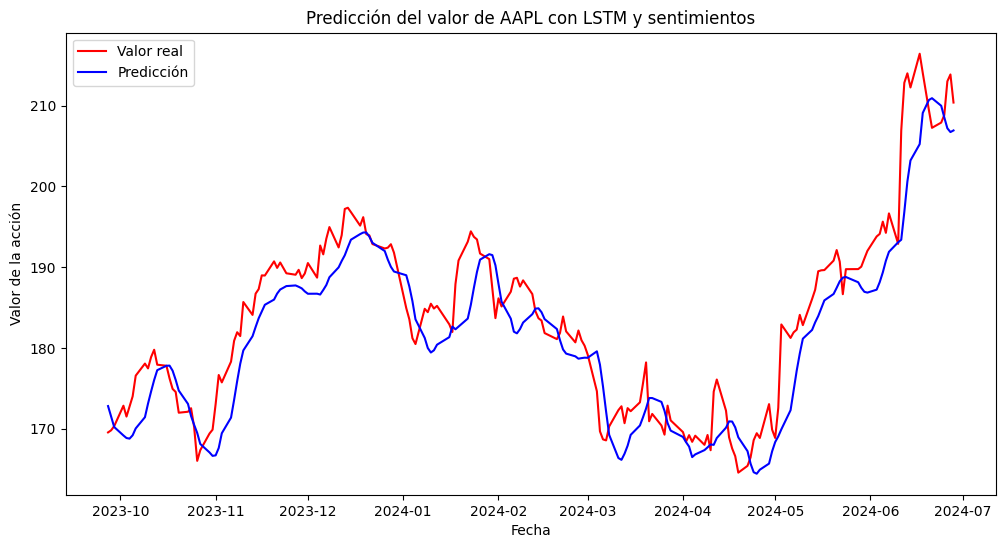

In [31]:
#Ajuste del modelo LSTM para usar los sentimientos
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Configuración del modelo LSTM
class LSTMModel(pl.LightningModule):
    def __init__(self, input_size=6, hidden_layer_size=100, output_size=1, lr=0.001):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.lr = lr
        self.criterion = nn.MSELoss()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Preprocesamiento de los datos para entrenar el modelo LSTM

# Usamos las columnas de 'Adj Close', medias móviles y los sentimientos
caracteristicas = ['Adj Close', 'MA_10', 'MA_30', 'MA_60', 'sentimiento_noticias', 'sentimiento_reddit']
set_entrenamiento = data.loc[:'2023-06-30', caracteristicas]
set_validacion = data.loc['2023-07-01':, caracteristicas]

# Escalado de los datos
sc = MinMaxScaler(feature_range=(0, 1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)
set_validacion_escalado = sc.transform(set_validacion)

# Preparación de datos para PyTorch
time_step = 60
X_train, Y_train = [], []
m = len(set_entrenamiento_escalado)

for i in range(time_step, m):
    X_train.append(set_entrenamiento_escalado[i-time_step:i])
    Y_train.append(set_entrenamiento_escalado[i, 0])  # Columna 'Adj Close'

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Entrenamiento del modelo LSTM
model = LSTMModel(input_size=len(caracteristicas))  # El tamaño de entrada ahora es 6
trainer = pl.Trainer(max_epochs=20, logger=False)
trainer.fit(model, train_loader)

# Preparar datos de validación para la predicción
X_test = []
for i in range(time_step, len(set_validacion_escalado)):
    X_test.append(set_validacion_escalado[i-time_step:i])

X_test = np.array(X_test)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Predicción
model.eval()
with torch.no_grad():
    prediccion = model(X_test).numpy()

# Desescalar la predicción
prediccion = sc.inverse_transform(np.concatenate([prediccion, np.zeros((prediccion.shape[0], len(caracteristicas)-1))], axis=1))[:, 0]

# Graficar las predicciones
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(set_validacion.index[time_step:], set_validacion['Adj Close'][time_step:], color='red', label='Valor real')
plt.plot(set_validacion.index[time_step:], prediccion, color='blue', label='Predicción')
plt.xlabel('Fecha')
plt.ylabel('Valor de la acción')
plt.title('Predicción del valor de AAPL con LSTM y sentimientos')
plt.legend()
plt.show()



### **resumen estadístico de los datos de sentimientos**

### **gráfico del sentimiento en el tiempo**

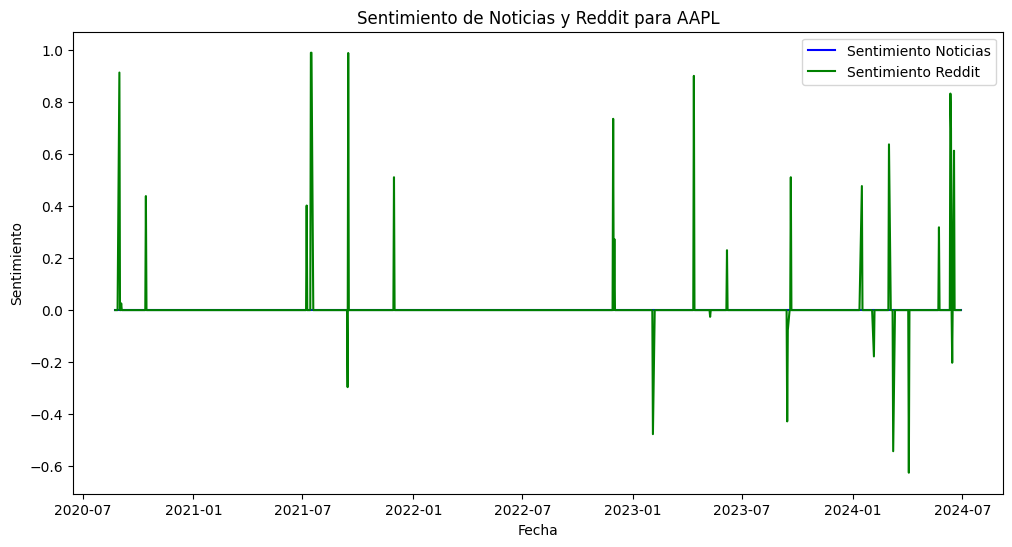

In [28]:
import matplotlib.pyplot as plt

# Graficar sentimiento de noticias y Reddit
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['sentimiento_noticias'], label='Sentimiento Noticias', color='blue')
plt.plot(data.index, data['sentimiento_reddit'], label='Sentimiento Reddit', color='green')
plt.xlabel('Fecha')
plt.ylabel('Sentimiento')
plt.title('Sentimiento de Noticias y Reddit para AAPL')
plt.legend()
plt.show()


In [29]:
# Días con el sentimiento más alto en noticias
print("Días con mayor sentimiento en noticias:")
print(data[['sentimiento_noticias']].sort_values(by='sentimiento_noticias', ascending=False).head())

# Días con el sentimiento más bajo en noticias
print("Días con menor sentimiento en noticias:")
print(data[['sentimiento_noticias']].sort_values(by='sentimiento_noticias').head())

# Días con el sentimiento más alto en Reddit
print("Días con mayor sentimiento en Reddit:")
print(data[['sentimiento_reddit']].sort_values(by='sentimiento_reddit', ascending=False).head())

# Días con el sentimiento más bajo en Reddit
print("Días con menor sentimiento en Reddit:")
print(data[['sentimiento_reddit']].sort_values(by='sentimiento_reddit').head())


Días con mayor sentimiento en noticias:
            sentimiento_noticias
Date                            
2020-08-24                   0.0
2023-04-17                   0.0
2023-03-07                   0.0
2023-03-08                   0.0
2023-03-09                   0.0
Días con menor sentimiento en noticias:
            sentimiento_noticias
Date                            
2020-08-24                   0.0
2023-03-07                   0.0
2023-03-08                   0.0
2023-03-09                   0.0
2023-03-10                   0.0
Días con mayor sentimiento en Reddit:
            sentimiento_reddit
Date                          
2021-07-15              0.9891
2021-07-16              0.9891
2021-09-15              0.9880
2020-08-31              0.9129
2023-04-12              0.9001
Días con menor sentimiento en Reddit:
            sentimiento_reddit
Date                          
2024-04-03            -0.62490
2024-03-08            -0.54230
2023-02-03            -0.47670
2023-09-14

## **Modelo 3. LSTM para varias acciones**

In [48]:
import yfinance as yf

# Descargar datos financieros de múltiples tickers
def download_data_multiple(tickers):
    datos_acciones = {}
    for ticker in tickers:
        data = yf.download(ticker, start='2020-06-01', end='2024-06-30')
        data['MA_10'] = data['Adj Close'].rolling(window=10).mean()
        data['MA_30'] = data['Adj Close'].rolling(window=30).mean()
        data['MA_60'] = data['Adj Close'].rolling(window=60).mean()
        data.dropna(inplace=True)
        datos_acciones[ticker] = data
    return datos_acciones

# Lista de tickers
tickers = ['AMZN', 'GOOGL', 'NVDA', 'MSFT', 'NFLX']

# Descargar datos de todas las acciones
datos_acciones = download_data_multiple(tickers)
print(f"Datos descargados para {len(datos_acciones)} acciones.")

# Descargar noticias de yfinance
def obtener_noticias_yfinance(ticker):
    stock = yf.Ticker(ticker)
    noticias = stock.news
    return noticias

# Descargar noticias para múltiples tickers
def obtener_noticias_multiple(tickers):
    noticias_acciones = {}
    for ticker in tickers:
        noticias_acciones[ticker] = obtener_noticias_yfinance(ticker)
    return noticias_acciones

# Obtener noticias para todas las acciones
noticias_yf_multiple = obtener_noticias_multiple(tickers)

# Implementar la función corregida para obtener posts de Reddit
import nest_asyncio
import asyncio
import asyncpraw

nest_asyncio.apply()

# Función asíncrona para obtener posts de Reddit para un ticker
async def obtener_reddit_async(ticker, cliente_id, cliente_secret, usuario, contraseña, user_agent, subreddit='WallStreetBets', limite=100):
    async with asyncpraw.Reddit(client_id=cliente_id,
                                client_secret=cliente_secret,
                                user_agent=user_agent,
                                username=usuario,
                                password=contraseña) as reddit:

        subreddit = await reddit.subreddit(subreddit)
        publicaciones = subreddit.search(ticker, limit=limite)
        datos = []
        async for post in publicaciones:
            datos.append({
                'titulo': post.title,
                'cuerpo': post.selftext,
                'fecha': post.created_utc
            })
    return datos

# Obtener posts de Reddit para múltiples tickers
def obtener_reddit_multiple(tickers, cliente_id, cliente_secret, usuario, contraseña, user_agent):
    reddit_posts_acciones = {}
    for ticker in tickers:
        reddit_posts_acciones[ticker] = asyncio.run(obtener_reddit_async(ticker, cliente_id, cliente_secret, usuario, contraseña, user_agent))
    return reddit_posts_acciones

# Información de autenticación de Reddit
cliente_id = "H3cf4dEtELCFz7w3z6eIKw"
cliente_secret = "lxNt3eDn3Y1XA57EIq3_Q92AQ_Ntyw"
usuario = "RoutineStrain7301"
contraseña = "Tavinr1717*"
user_agent = "proyectogustav"

# Obtener posts de Reddit para todas las acciones
reddit_posts_multiple = obtener_reddit_multiple(tickers, cliente_id, cliente_secret, usuario, contraseña, user_agent)

# Mostrar un resumen de las primeras noticias y posts obtenidos
for ticker in tickers:
    print(f"Noticias de {ticker}:")
    for noticia in noticias_yf_multiple[ticker][:3]:
        print(f"Fecha: {noticia['providerPublishTime']}")
        print(f"Fuente: {noticia['publisher']}")
        print(f"Titulo: {noticia['title']}")
        print(f"Enlace: {noticia['link']}\n")

    print(f"Posts de Reddit sobre {ticker}:")
    for post in reddit_posts_multiple[ticker][:3]:
        print(f"Fecha: {post['fecha']}")
        print(f"Título: {post['titulo']}")
        print(f"Cuerpo: {post['cuerpo']}\n")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Datos descargados para 5 acciones.
Noticias de AMZN:
Fecha: 1726261019
Fuente: Financial Times
Titulo: US targets trade loophole used by ecommerce groups Temu and Shein
Enlace: https://finance.yahoo.com/news/us-targets-trade-loophole-used-150106856.html

Fecha: 1726249585
Fuente: Insider Monkey
Titulo: Amazon.com, Inc. (AMZN): A Bull Case Theory
Enlace: https://finance.yahoo.com/news/amazon-com-inc-amzn-bull-174625590.html

Fecha: 1726242128
Fuente: Yahoo Finance Video
Titulo: Oracle is 'advantaged.' Analyst explains why.
Enlace: https://finance.yahoo.com/video/oracle-advantaged-analyst-explains-why-154208164.html

Posts de Reddit sobre AMZN:
Fecha: 1719173674.0
Título: AMZN to go above
Cuerpo: I think this year Amazon stock/calls price is pretty undervalued atm.

My guess is they will crush any labor unions and have strong revenue growth this year.

My play is buying $230 calls exp 10/15 trading at $1.73 when market opens tomorrow 

What are everyone’s thoughts?

Fecha: 1723906617.0
T

## **Procesar noticias y sentimientos para múltiples acciones**

In [49]:
# Procesar noticias y posts de Reddit para múltiples acciones
def procesar_datos_sentimientos_multiple(noticias_yf_multiple, reddit_posts_multiple):
    sentimientos_acciones = {}
    for ticker in tickers:
        noticias_procesadas = procesar_noticias_yf(noticias_yf_multiple[ticker])
        reddit_procesados = procesar_reddit_posts(reddit_posts_multiple[ticker])

        # Crear DataFrames y calcular sentimiento promedio diario
        noticias_df = pd.DataFrame(noticias_procesadas)
        noticias_df['fecha'] = noticias_df['fecha'].dt.date
        sentimiento_noticias_diario = noticias_df.groupby('fecha')['sentimiento'].mean()

        reddit_df = pd.DataFrame(reddit_procesados)
        reddit_df['fecha'] = reddit_df['fecha'].dt.date
        sentimiento_reddit_diario = reddit_df.groupby('fecha')['sentimiento'].mean()

        sentimientos_acciones[ticker] = {'noticias': sentimiento_noticias_diario, 'reddit': sentimiento_reddit_diario}

    return sentimientos_acciones

# Procesar los sentimientos para todas las acciones
sentimientos_acciones = procesar_datos_sentimientos_multiple(noticias_yf_multiple, reddit_posts_multiple)


## **Integrar sentimientos con los datos financieros**

In [50]:
# Añadir los sentimientos a los datos financieros
for ticker in tickers:
    data = datos_acciones[ticker]
    data['sentimiento_noticias'] = data.index.map(sentimientos_acciones[ticker]['noticias'])
    data['sentimiento_reddit'] = data.index.map(sentimientos_acciones[ticker]['reddit'])
    data['sentimiento_noticias'].fillna(0, inplace=True)
    data['sentimiento_reddit'].fillna(0, inplace=True)
    datos_acciones[ticker] = data


Modificar el modelo LSTM para varias acciones

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 43.2 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Entrenando modelo para AMZN...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


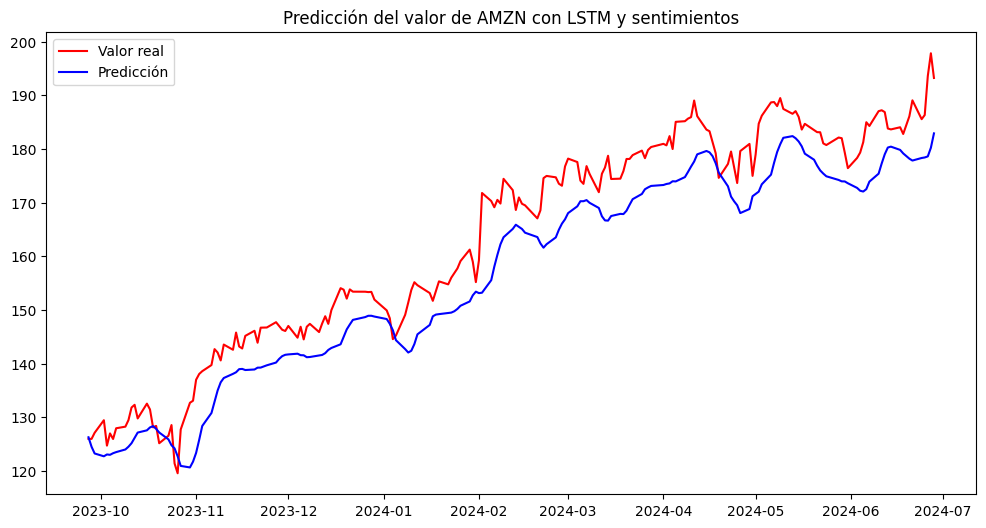

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 43.2 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Entrenando modelo para GOOGL...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


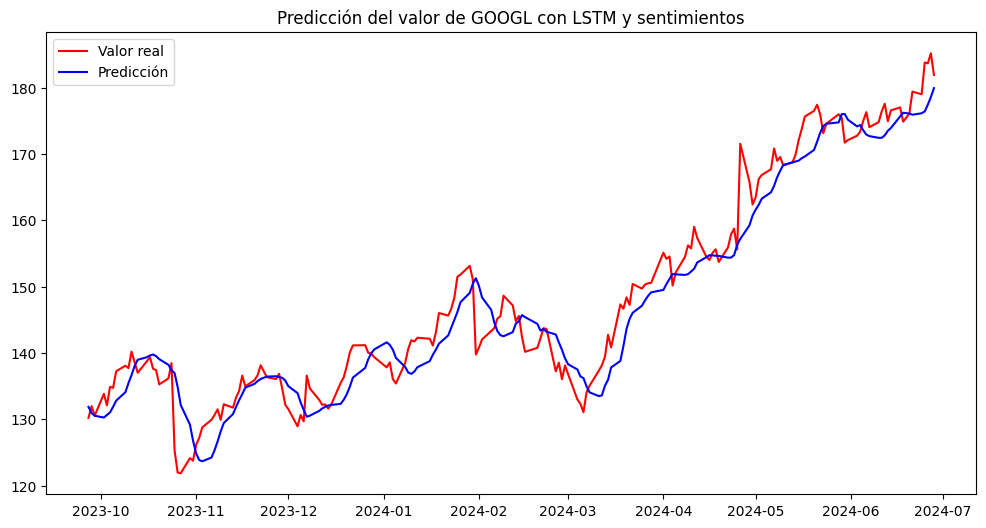

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 43.2 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Entrenando modelo para NVDA...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


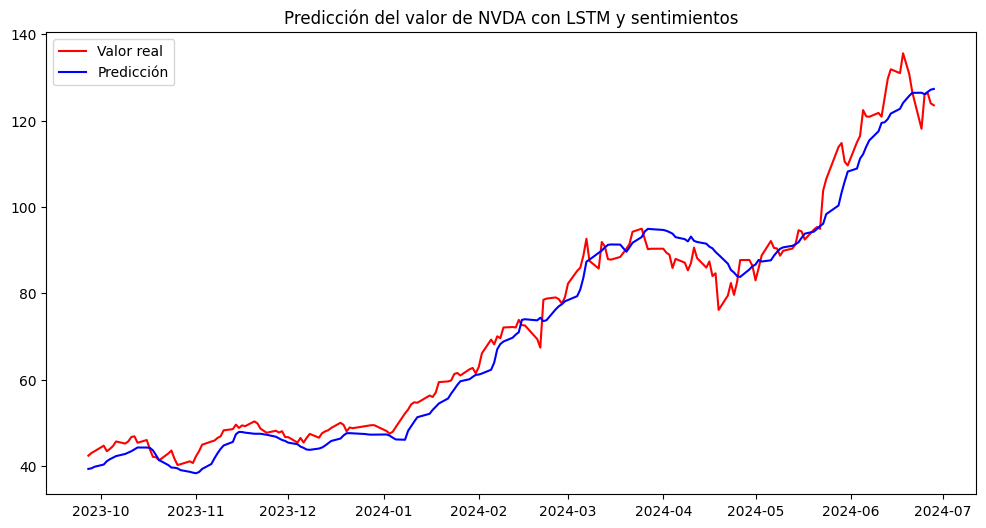

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 43.2 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Entrenando modelo para MSFT...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


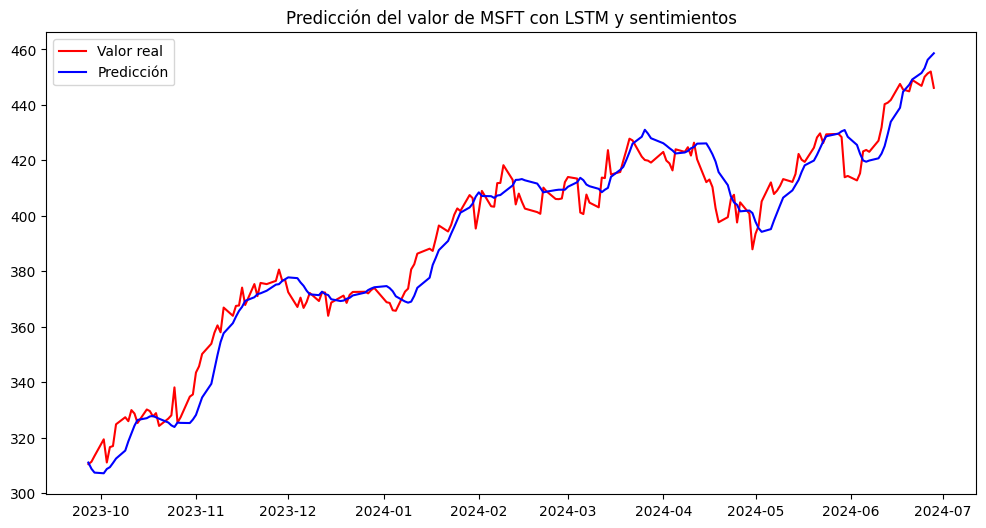

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 43.2 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Entrenando modelo para NFLX...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


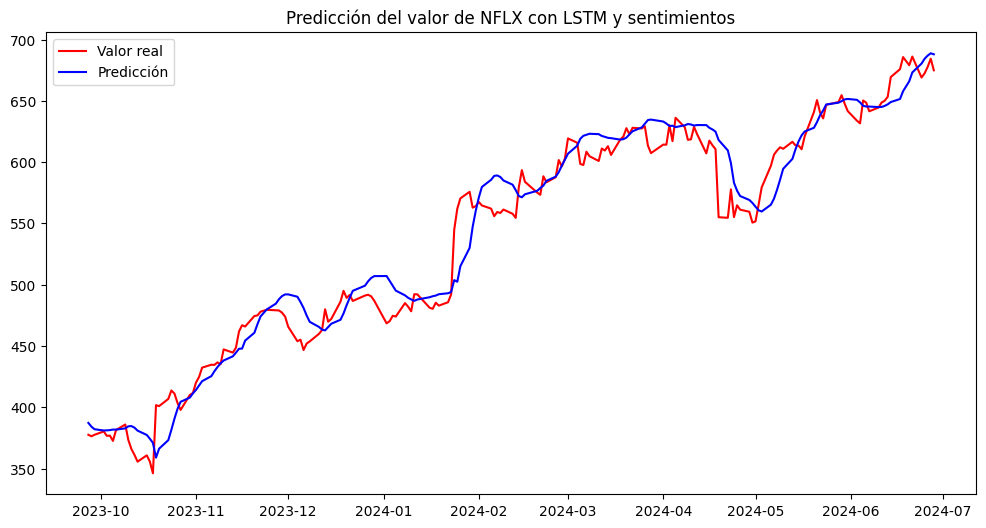

In [42]:
for ticker in tickers:
    print(f"Entrenando modelo para {ticker}...")
    data = datos_acciones[ticker]
    caracteristicas = ['Adj Close', 'MA_10', 'MA_30', 'MA_60', 'sentimiento_noticias', 'sentimiento_reddit']

    # Preprocesar datos de entrenamiento y validación
    set_entrenamiento = data.loc[:'2023-06-30', caracteristicas]
    set_validacion = data.loc['2023-07-01':, caracteristicas]

    # Escalado de los datos
    sc = MinMaxScaler(feature_range=(0, 1))
    set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)
    set_validacion_escalado = sc.transform(set_validacion)

    # Preparación de los datos para el modelo
    X_train, Y_train = [], []
    m = len(set_entrenamiento_escalado)
    for i in range(time_step, m):
        X_train.append(set_entrenamiento_escalado[i-time_step:i])
        Y_train.append(set_entrenamiento_escalado[i, 0])

    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)

    # Crear DataLoader
    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Crear y entrenar el modelo
    model = LSTMModel(input_size=len(caracteristicas))
    trainer = pl.Trainer(max_epochs=20, logger=False)
    trainer.fit(model, train_loader)

    # Hacer predicciones
    X_test = []
    for i in range(time_step, len(set_validacion_escalado)):
        X_test.append(set_validacion_escalado[i-time_step:i])

    X_test = np.array(X_test)
    X_test = torch.tensor(X_test, dtype=torch.float32)

    # Predicción
    model.eval()
    with torch.no_grad():
        prediccion = model(X_test).numpy()

    # Desescalar la predicción
    prediccion = sc.inverse_transform(np.concatenate([prediccion, np.zeros((prediccion.shape[0], len(caracteristicas)-1))], axis=1))[:, 0]

    # Graficar las predicciones
    plt.figure(figsize=(12, 6))
    plt.plot(set_validacion.index[time_step:], set_validacion['Adj Close'][time_step:], color='red', label='Valor real')
    plt.plot(set_validacion.index[time_step:], prediccion, color='blue', label='Predicción')
    plt.title(f"Predicción del valor de {ticker} con LSTM y sentimientos")
    plt.legend()
    plt.show()


## **Portafolio**

Rendimientos esperados diarios (Top 5):
AAPL    0.001129
AMZN    0.001705
GME     0.002736
dtype: float64

Matriz de covarianza diaria (Top 5):
          AAPL      AMZN       GME
AAPL  0.000048  0.000013  0.000053
AMZN  0.000013  0.000053  0.000007
GME   0.000053  0.000007  0.002822
Pesos óptimos del portafolio (Top 5):
AAPL: 0.2000
AMZN: 0.4000
GME: 0.4000

Retorno esperado del portafolio: 0.0020
Volatilidad del portafolio: 0.0218
Ratio de Sharpe del portafolio: -0.1375


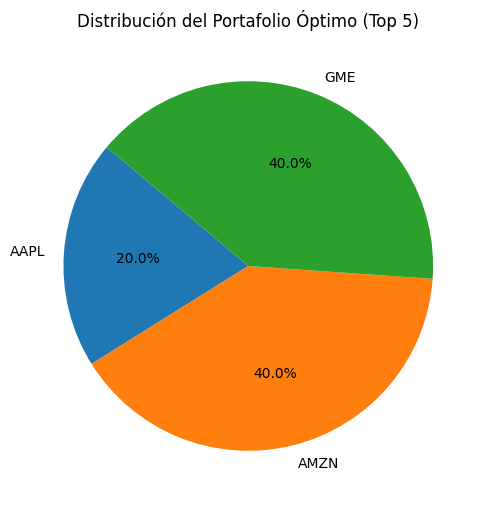

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Supongamos que 'future_prices_df' es un DataFrame con las predicciones de precios de las 5 acciones (AMZN, GOOGL, NVDA, MSFT, NFLX)
# Cálculo de rendimientos diarios esperados y matriz de covarianza
expected_returns_daily = future_prices_df.pct_change().mean()
cov_matrix_daily = future_prices_df.pct_change().cov()

# Excluir acciones con rendimientos esperados negativos
positive_return_tickers = expected_returns_daily[expected_returns_daily > 0].index
expected_returns_daily = expected_returns_daily[positive_return_tickers]
cov_matrix_daily = cov_matrix_daily.loc[positive_return_tickers, positive_return_tickers]

# Como estamos trabajando con 5 acciones, seleccionamos todas ellas
top_tickers = positive_return_tickers
expected_returns_daily_top = expected_returns_daily[top_tickers]
cov_matrix_daily_top = cov_matrix_daily.loc[top_tickers, top_tickers]

# Mostrar los rendimientos esperados diarios y matriz de covarianza
print("Rendimientos esperados diarios (Top 5):")
print(expected_returns_daily_top)
print("\nMatriz de covarianza diaria (Top 5):")
print(cov_matrix_daily_top)

# Función para calcular el rendimiento y la volatilidad del portafolio
def portfolio_performance(weights, expected_returns, cov_matrix):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_std

# Función objetivo para la optimización (maximización del Sharpe ratio)
def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate=0.01):
    p_returns, p_std = portfolio_performance(weights, expected_returns, cov_matrix)
    return -(p_returns - risk_free_rate) / p_std

# Restricciones y límites para la optimización
num_assets = len(expected_returns_daily_top)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # La suma de los pesos debe ser 1
bounds = tuple((0.05, 0.4) for _ in range(num_assets))  # Limitar el peso de cada acción entre 5% y 33%

# Inicializar pesos aleatorios
initial_weights = num_assets * [1. / num_assets]

# Optimización para maximizar el Sharpe ratio
opt_results = minimize(negative_sharpe_ratio, initial_weights, args=(expected_returns_daily_top, cov_matrix_daily_top),
                       method='SLSQP', bounds=bounds, constraints=constraints)

# Pesos óptimos del portafolio
optimal_weights = opt_results.x

# Mostrar los pesos óptimos para cada acción
print("Pesos óptimos del portafolio (Top 5):")
for ticker, weight in zip(top_tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

# Evaluar el rendimiento y la volatilidad del portafolio optimizado
p_returns, p_std = portfolio_performance(optimal_weights, expected_returns_daily_top, cov_matrix_daily_top)
sharpe_ratio = (p_returns - 0.005) / p_std  # Suponiendo una tasa libre de riesgo del 0.5%

print(f"\nRetorno esperado del portafolio: {p_returns:.4f}")
print(f"Volatilidad del portafolio: {p_std:.4f}")
print(f"Ratio de Sharpe del portafolio: {sharpe_ratio:.4f}")

# Visualización de la distribución del portafolio optimizado
plt.figure(figsize=(10, 6))
plt.pie(optimal_weights, labels=top_tickers, autopct='%1.1f%%', startangle=140)
plt.title('Distribución del Portafolio Óptimo (Top 5)')
plt.show()


## **MODELO 3.2 Modelo 3.1 Incluyendo metricas**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 43.2 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | tr

Datos descargados para 5 acciones.
Entrenando modelo para AMZN...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Métricas para AMZN:
Mean Squared Error (MSE): 18.349100570125973
Mean Absolute Error (MAE): 3.300515692901561
R² Score: 0.9557209014372943


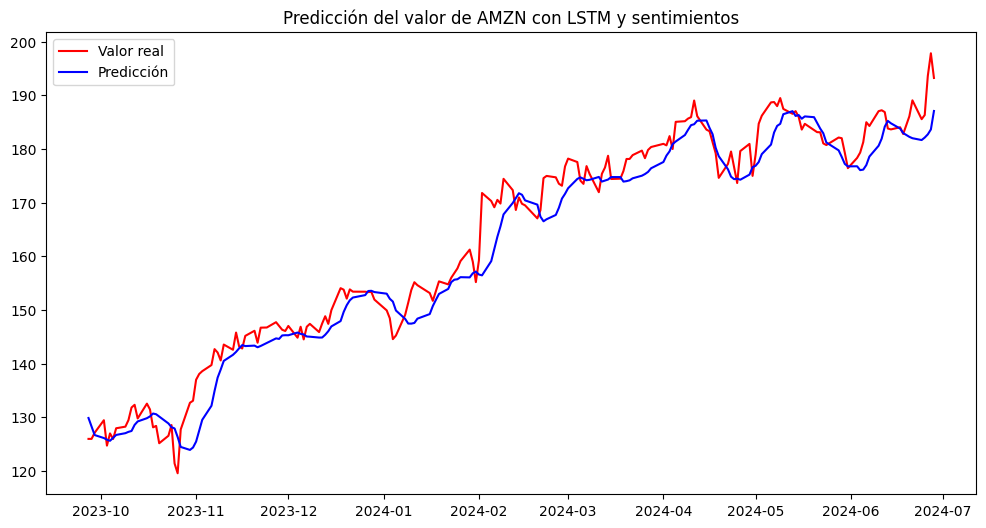

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 43.2 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Entrenando modelo para GOOGL...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Métricas para GOOGL:
Mean Squared Error (MSE): 19.463882390747802
Mean Absolute Error (MAE): 3.5884728543277387
R² Score: 0.9252667298598332


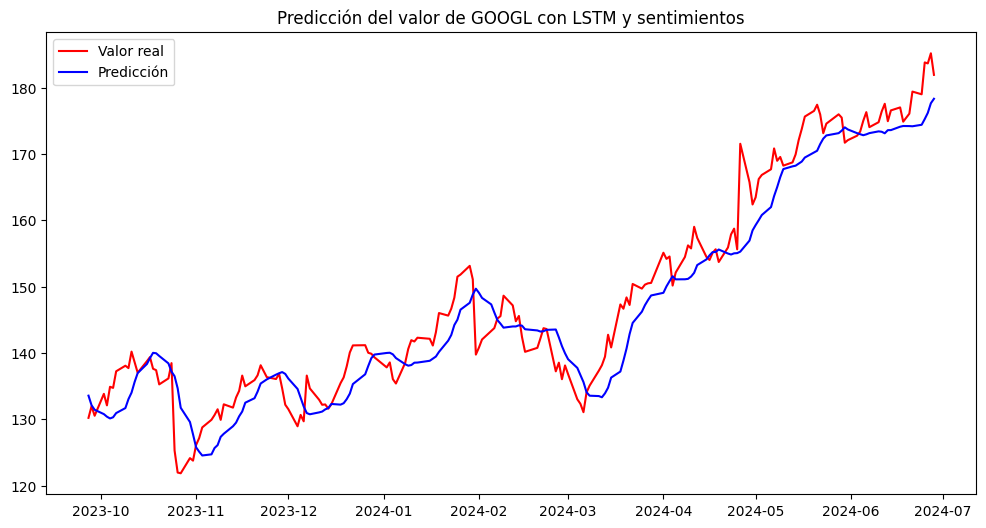

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 43.2 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Entrenando modelo para NVDA...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Métricas para NVDA:
Mean Squared Error (MSE): 147.95259514969032
Mean Absolute Error (MAE): 9.05285616535119
R² Score: 0.7820534061085287


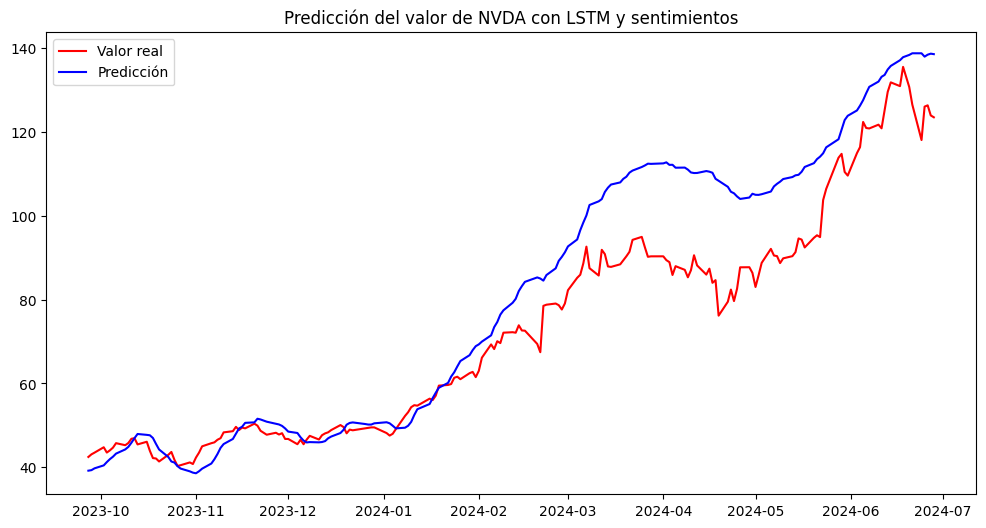

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 43.2 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Entrenando modelo para MSFT...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Métricas para MSFT:
Mean Squared Error (MSE): 150.0258732925298
Mean Absolute Error (MAE): 10.366114045422469
R² Score: 0.8764682177007007


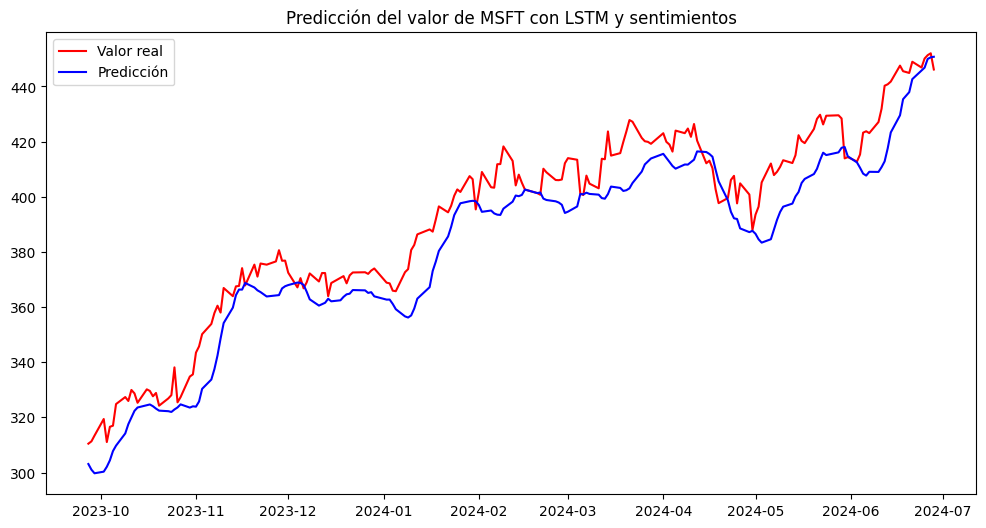

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 43.2 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Entrenando modelo para NFLX...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Métricas para NFLX:
Mean Squared Error (MSE): 384.92914101981796
Mean Absolute Error (MAE): 14.61251180522684
R² Score: 0.9544513805076814


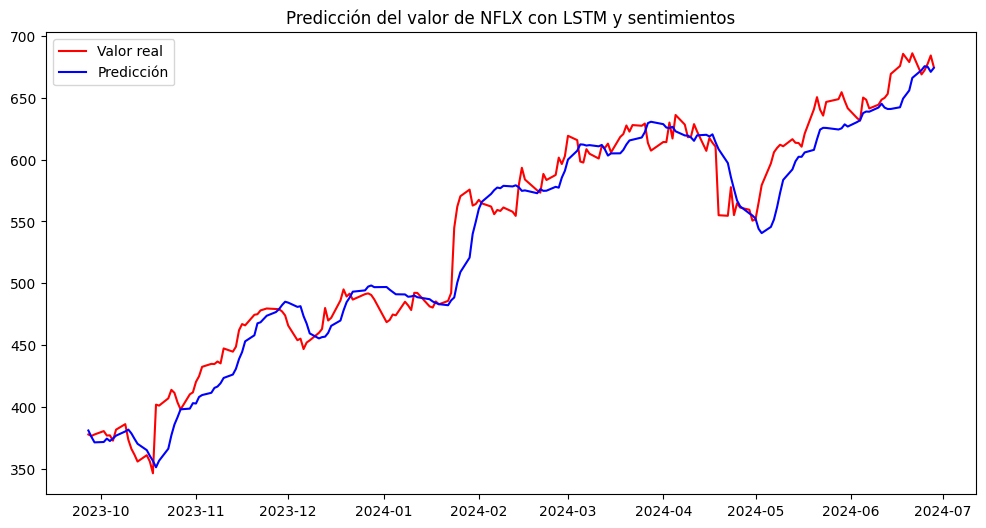

In [53]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Lista de tickers
tickers = ['AMZN', 'GOOGL', 'NVDA', 'MSFT', 'NFLX']

# Descargar datos financieros de múltiples tickers
def download_data_multiple(tickers):
    datos_acciones = {}
    for ticker in tickers:
        data = yf.download(ticker, start='2020-06-01', end='2024-06-30')
        data['MA_10'] = data['Adj Close'].rolling(window=10).mean()
        data['MA_30'] = data['Adj Close'].rolling(window=30).mean()
        data['MA_60'] = data['Adj Close'].rolling(window=60).mean()
        data.dropna(inplace=True)
        datos_acciones[ticker] = data
    return datos_acciones

# Descargar datos de todas las acciones
datos_acciones = download_data_multiple(tickers)
print(f"Datos descargados para {len(datos_acciones)} acciones.")

# Función para añadir columnas de sentimiento (simuladas aquí para ejemplo)
def agregar_sentimientos(datos_acciones):
    for ticker, data in datos_acciones.items():
        # Aquí puedes reemplazar con los valores reales de sentimiento de noticias y Reddit
        data['sentimiento_noticias'] = np.random.uniform(-1, 1, len(data))
        data['sentimiento_reddit'] = np.random.uniform(-1, 1, len(data))
        datos_acciones[ticker] = data
    return datos_acciones

# Añadir sentimientos simulados a los datos financieros
datos_acciones = agregar_sentimientos(datos_acciones)

# Clase LSTM en PyTorch Lightning
class LSTMModel(pl.LightningModule):
    def __init__(self, input_size=6, hidden_layer_size=100, output_size=1, lr=0.001):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.lr = lr
        self.criterion = nn.MSELoss()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Entrenamiento del modelo LSTM y generación de predicciones con métricas
for ticker in tickers:
    print(f"Entrenando modelo para {ticker}...")
    data = datos_acciones[ticker]
    caracteristicas = ['Adj Close', 'MA_10', 'MA_30', 'MA_60', 'sentimiento_noticias', 'sentimiento_reddit']

    # Preprocesar datos de entrenamiento y validación
    set_entrenamiento = data.loc[:'2023-06-30', caracteristicas]
    set_validacion = data.loc['2023-07-01':, caracteristicas]

    # Escalado de los datos
    sc = MinMaxScaler(feature_range=(0, 1))
    set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)
    set_validacion_escalado = sc.transform(set_validacion)

    # Preparación de los datos para el modelo
    time_step = 60
    X_train, Y_train = [], []
    m = len(set_entrenamiento_escalado)
    for i in range(time_step, m):
        X_train.append(set_entrenamiento_escalado[i-time_step:i])
        Y_train.append(set_entrenamiento_escalado[i, 0])

    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)

    # Crear DataLoader
    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Crear y entrenar el modelo
    model = LSTMModel(input_size=len(caracteristicas))
    trainer = pl.Trainer(max_epochs=20, logger=False)
    trainer.fit(model, train_loader)

    # Preparar datos de validación para la predicción
    X_test = []
    for i in range(time_step, len(set_validacion_escalado)):
        X_test.append(set_validacion_escalado[i-time_step:i])

    X_test = np.array(X_test)
    X_test = torch.tensor(X_test, dtype=torch.float32)

    # Predicción
    model.eval()
    with torch.no_grad():
        prediccion = model(X_test).numpy()

    # Desescalar la predicción
    prediccion = sc.inverse_transform(np.concatenate([prediccion, np.zeros((prediccion.shape[0], len(caracteristicas)-1))], axis=1))[:, 0]

    # Calcular las métricas de evaluación
    mse = mean_squared_error(set_validacion['Adj Close'][time_step:], prediccion)
    mae = mean_absolute_error(set_validacion['Adj Close'][time_step:], prediccion)
    r2 = r2_score(set_validacion['Adj Close'][time_step:], prediccion)

    # Mostrar las métricas
    print(f"Métricas para {ticker}:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R² Score: {r2}")

    # Graficar las predicciones
    plt.figure(figsize=(12, 6))
    plt.plot(set_validacion.index[time_step:], set_validacion['Adj Close'][time_step:], color='red', label='Valor real')
    plt.plot(set_validacion.index[time_step:], prediccion, color='blue', label='Predicción')
    plt.title(f"Predicción del valor de {ticker} con LSTM y sentimientos")
    plt.legend()
    plt.show()


## **MODELO 3.3. Intentando Optimizar modelo 3**

- Ajuste del tamaño de las capas ocultas
- Tuning del learning rate
- Incorporar Dropout
- Early Stopping

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      

Datos descargados para 5 acciones.
Entrenando modelo para AMZN...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 0.028
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.010
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.002
INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric train_loss did not improve in the last 5 records. Best score: 0.002. Signaling Trainer to stop.


Métricas para AMZN:
Mean Squared Error (MSE): 83.51032446136172
Mean Absolute Error (MAE): 7.9922795561034015
R² Score: 0.7984772128913789


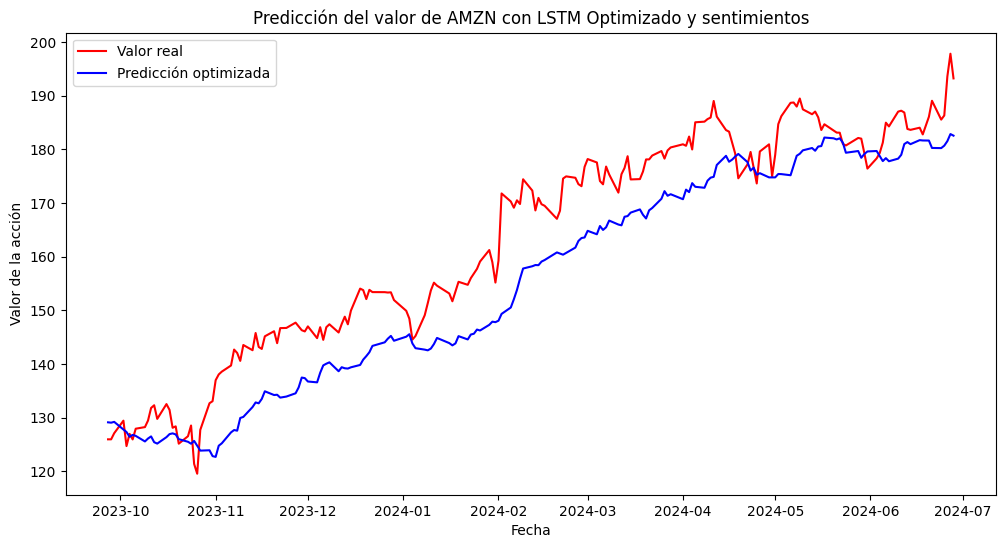

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 69.6 K | train
1 | dropout   | Dropout | 0      | train
2 | linear    | Linear  | 129    | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
69.8 K    Trainable params
0         Non-trainable params
69

Entrenando modelo para GOOGL...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 0.029
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.017
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.009
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.007
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.005
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.003
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.001
INFO:pytorch_lightni

Métricas para GOOGL:
Mean Squared Error (MSE): 20.81626738162817
Mean Absolute Error (MAE): 3.7158448797743997
R² Score: 0.9200741300060129


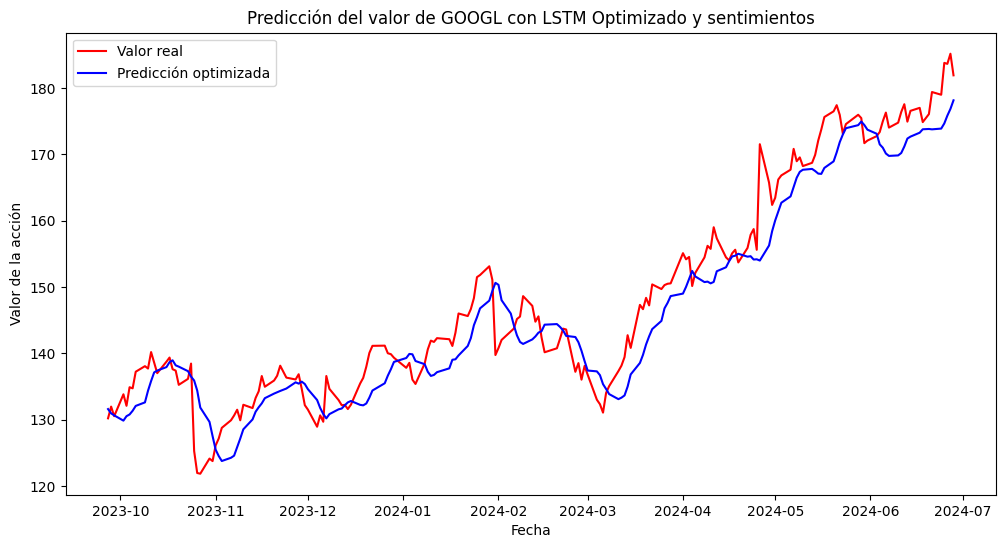

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 69.6 K | train
1 | dropout   | Dropout | 0      | train
2 | linear    | Linear  | 129    | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
69.8 K    Trainable params
0         Non-trainable params
69

Entrenando modelo para NVDA...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 0.016
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.006
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.004
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
INFO:pytorch_lightni

Métricas para NVDA:
Mean Squared Error (MSE): 18.344204882190233
Mean Absolute Error (MAE): 3.1867430530459147
R² Score: 0.9729774461362057


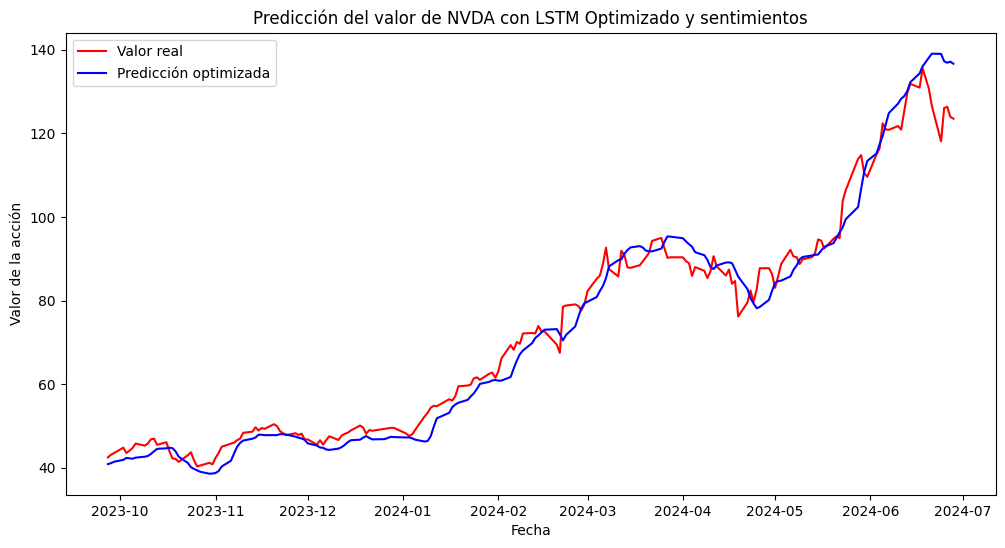

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 69.6 K | train
1 | dropout   | Dropout | 0      | train
2 | linear    | Linear  | 129    | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
69.8 K    Trainable params
0         Non-trainable params
69

Entrenando modelo para MSFT...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 0.029
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.014
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.005
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.003
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric train_loss did not improve in the last 5 records. Best score: 0.003. Signaling Trainer to stop.


Métricas para MSFT:
Mean Squared Error (MSE): 223.7445526169298
Mean Absolute Error (MAE): 12.991840851215247
R² Score: 0.8157680221555161


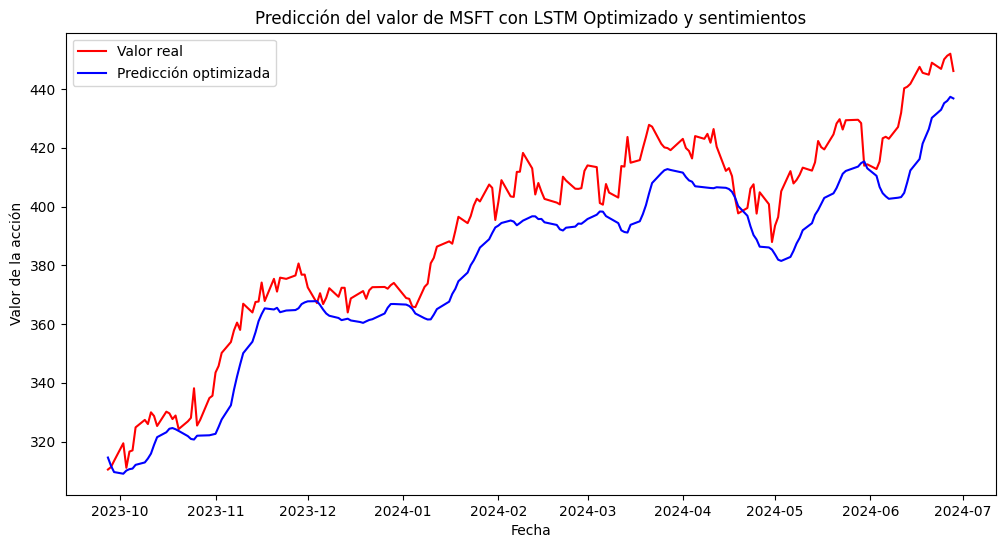

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 69.6 K | train
1 | dropout   | Dropout | 0      | train
2 | linear    | Linear  | 129    | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
69.8 K    Trainable params
0         Non-trainable params
69

Entrenando modelo para NFLX...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 0.041
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.010
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.006
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.002
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
INFO:pytorch_lightni

Métricas para NFLX:
Mean Squared Error (MSE): 361.06184781295445
Mean Absolute Error (MAE): 14.276744095918325
R² Score: 0.9572755944752466


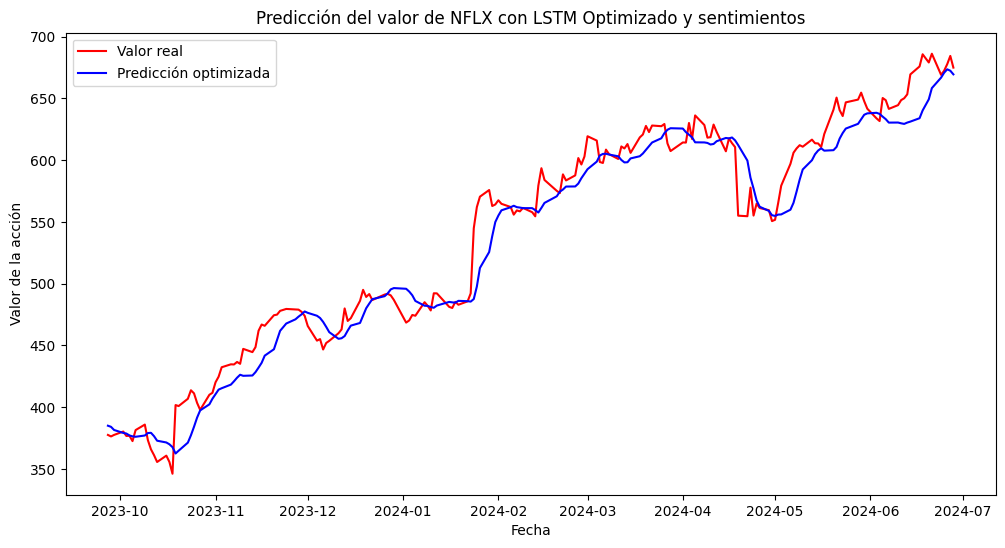

In [54]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Modelo LSTM optimizado
class OptimizedLSTMModel(pl.LightningModule):
    def __init__(self, input_size=6, hidden_layer_size=128, output_size=1, lr=0.001, dropout_rate=0.2):
        super(OptimizedLSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.lr = lr
        self.criterion = nn.MSELoss()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Aplicar dropout
        predictions = self.linear(lstm_out[:, -1])
        return predictions

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'train_loss'
            }
        }

# Descargar datos financieros de múltiples tickers
def download_data_multiple(tickers):
    datos_acciones = {}
    for ticker in tickers:
        data = yf.download(ticker, start='2020-06-01', end='2024-06-30')
        data['MA_10'] = data['Adj Close'].rolling(window=10).mean()
        data['MA_30'] = data['Adj Close'].rolling(window=30).mean()
        data['MA_60'] = data['Adj Close'].rolling(window=60).mean()
        data.dropna(inplace=True)
        datos_acciones[ticker] = data
    return datos_acciones

# Lista de tickers
tickers = ['AMZN', 'GOOGL', 'NVDA', 'MSFT', 'NFLX']

# Descargar datos de todas las acciones
datos_acciones = download_data_multiple(tickers)
print(f"Datos descargados para {len(datos_acciones)} acciones.")

# Función para añadir columnas de sentimiento (simuladas aquí para ejemplo)
def agregar_sentimientos(datos_acciones):
    for ticker, data in datos_acciones.items():
        data['sentimiento_noticias'] = np.random.uniform(-1, 1, len(data))
        data['sentimiento_reddit'] = np.random.uniform(-1, 1, len(data))
        datos_acciones[ticker] = data
    return datos_acciones

# Añadir sentimientos simulados a los datos financieros
datos_acciones = agregar_sentimientos(datos_acciones)

# Entrenamiento del modelo LSTM optimizado y generación de predicciones con métricas
for ticker in tickers:
    print(f"Entrenando modelo para {ticker}...")
    data = datos_acciones[ticker]
    caracteristicas = ['Adj Close', 'MA_10', 'MA_30', 'MA_60', 'sentimiento_noticias', 'sentimiento_reddit']

    # Preprocesar datos de entrenamiento y validación
    set_entrenamiento = data.loc[:'2023-06-30', caracteristicas]
    set_validacion = data.loc['2023-07-01':, caracteristicas]

    # Escalado de los datos
    sc = MinMaxScaler(feature_range=(0, 1))
    set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)
    set_validacion_escalado = sc.transform(set_validacion)

    # Preparación de los datos para el modelo
    time_step = 60
    X_train, Y_train = [], []
    m = len(set_entrenamiento_escalado)
    for i in range(time_step, m):
        X_train.append(set_entrenamiento_escalado[i-time_step:i])
        Y_train.append(set_entrenamiento_escalado[i, 0])

    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)

    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Aplicar Early Stopping para detener el entrenamiento cuando la pérdida no mejore
    early_stop_callback = EarlyStopping(
        monitor='train_loss',
        patience=5,
        verbose=True,
        mode='min'
    )

    # Entrenamiento del modelo LSTM optimizado
    model = OptimizedLSTMModel(input_size=len(caracteristicas), hidden_layer_size=128, lr=0.001, dropout_rate=0.2)
    trainer = pl.Trainer(max_epochs=50, logger=False, callbacks=[early_stop_callback])
    trainer.fit(model, train_loader)

    # Preparar datos de validación para la predicción
    X_test = []
    for i in range(time_step, len(set_validacion_escalado)):
        X_test.append(set_validacion_escalado[i-time_step:i])

    X_test = np.array(X_test)
    X_test = torch.tensor(X_test, dtype=torch.float32)

    # Predicción
    model.eval()
    with torch.no_grad():
        prediccion = model(X_test).numpy()

    # Desescalar la predicción
    prediccion = sc.inverse_transform(np.concatenate([prediccion, np.zeros((prediccion.shape[0], len(caracteristicas)-1))], axis=1))[:, 0]

    # Calcular las métricas de evaluación
    mse = mean_squared_error(set_validacion['Adj Close'][time_step:], prediccion)
    mae = mean_absolute_error(set_validacion['Adj Close'][time_step:], prediccion)
    r2 = r2_score(set_validacion['Adj Close'][time_step:], prediccion)

    # Mostrar las métricas
    print(f"Métricas para {ticker}:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R² Score: {r2}")

    # Graficar las predicciones optimizadas
    plt.figure(figsize=(12, 6))
    plt.plot(set_validacion.index[time_step:], set_validacion['Adj Close'][time_step:], color='red', label='Valor real')
    plt.plot(set_validacion.index[time_step:], prediccion, color='blue', label='Predicción optimizada')
    plt.xlabel('Fecha')
    plt.ylabel('Valor de la acción')
    plt.title(f'Predicción del valor de {ticker} con LSTM Optimizado y sentimientos')
    plt.legend()
    plt.show()


### **Conclusion Modelo 3. **

Complejizar la red no mejora los resultados, se incrementan los valores de MSE y disminuye r^2